# Using QAOA to solve a MIS problem

In [1]:
import numpy as np
import igraph
from itertools import combinations

import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register, Simulation
from pulser.devices import Chadoq2

from scipy.optimize import minimize

## 1. Introduction 

In this tutorial, we illustrate how to solve the Maximum Independent Set (MIS) problem using the Quantum Approximate Optimization Algorithm procedure on a platform of Rydberg atoms in analog mode, using Pulser. 

For more details about this problem and how to encode it on a Rydberg atom quantum processor, see [Pichler, et al., 2018](https://arxiv.org/abs/1808.10816), [Henriet, 2020]( https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.012335) and [Dalyac, et al., 2020]( https://arxiv.org/abs/2012.14859]).

Consider an undirected graph composed of a set of vertices connected by unweighted edges. An independent set of this graph is a subset of vertices where any two elements of this subset are not connected by an edge. The Maximum Independent Set (MIS) corresponds to the largest of such subsets, and it is in general an NP-complete problem to determine the MIS of a graph. 

The MIS problem has several interesting applications, such as portfolio diversification in
finance, or broadcast systems (wifi or cellular network) optimization.

For example, assume an ensemble of identical radio transmitters over French cities that each have the same radius of transmission. It was quickly realized that two transmitters with close or equal frequencies could interfere with one another, hence the necessity to assign non-interfering frequencies to overlapping transmiting towers. Because of the limited amount of bandwith space, some towers have to be assigned the same or close frequencies. The MIS of a graph of towers indicate the maximum number of towers that can have close or equal given frequency (red points). 

<center>
<img src="../../docs/source/files/France_MIS.png" alt="MIS map France" width="650">
</center>

Here, we will show how to solve the MIS problem on Unit-Disk (UD) graphs with an excellent approximation.

When looking for the MIS of a graph, we separate the nodes into two distinct classes: an independence one and the others. We can attribute a status $z$ to each node, where $z_i = 1$  if node $i$ is attributed to the independent set, and $z_i=0$ otherwise. The Maximum Independent Set corresponds to  the minima of the following cost function: 

$$
C(z_1,\dots,z_N) = -\sum_{i=1}^N z_i + U \sum_{\langle i,j \rangle}z_i z_j
$$

where $U \gg 1$  and $\langle i,j \rangle$ represents adjacent nodes (i.e. there is a link between node $i$ and $j$). In this cost function, we want to promote a maximal number of atoms to the $1$ state, but the fact that $U \gg 1$  strongly penalizes two adjacent vertices in state $1$. The minimum of $C(z_0,\dots,z_N)$ therefore corresponds to the maximum independent set of the graph.

Interestingly, the operator $\hat{C}$ associated with the cost function of the previous equation can be natively realized on a neutral atom platform with some constraints on the graph edges. We map a  ground state and a Rydberg state of each atom to a two-level system, where $|1 \rangle = |r \rangle$ is a Rydberg state and $|0 \rangle = |g \rangle$ is a ground state. An atom in a Rydberg state has an excited electron with a very high principal quantum number and therefore exhibits a huge electric dipole moment. As such, when two atoms are excited to Rydberg states, they exhibit a strong van der Waals interaction. Placing $N$ atoms at positions $\textbf{r}_j$ in a 2D plane, and coupling the ground state $|0\rangle$ to the Rydberg state $|1\rangle$ with a laser system enables the realization of the Hamiltonian :

$$
H= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2}  \sigma_i^z+\sum_{j<i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j.
\label{eq:ising_Hamiltonian}
$$

Here, $\Omega$ and $\delta$ are respectively the Rabi frequency and detuning of the laser system and $\hbar$ is the reduced Planck constant. The first two terms of the equation govern the transition between states $|0\rangle$ and $|1 \rangle$ induced by the laser, while the third term represents the repulsive Van der Waals interaction between atoms in the $|0\rangle$ state. More precisely, $n_i = \frac 12 (\sigma_i
^z + 1)$ counts the number of Rydberg excitations at position $i$. The interaction strength between two atoms decays as $|\textbf{r}_i-\textbf{r}_j|^{-6}$.

### From a graph to an atomic register

We now illustrate how one can use Pulser and a neutral-atom device to find the MIS of a UD-graph. Because the quantum platform is emulated in this notebook, we restrict the number of atoms to 5, just to show a proof-of-concept.

A link in the graph corresponds to two atoms that are within the Rydberg Blockade Radius (RBR) of each other. The radius of RBR is directly linked to the Rabi frequency $\Omega$ and is obtained using `Chadoq2.rydberg_blockade_radius()`. In this notebook, $\Omega$ is fixed to a frequency of 1 rad/µs.

In [2]:
def pos_to_graph(pos):
    rb = Chadoq2.rydberg_blockade_radius(1.)
    g = igraph.Graph()
    N = len(pos)
    edges = [[m,n] for m,n in combinations(range(N), r=2) if np.linalg.norm(pos[m] - pos[n]) < rb]           
    g.add_vertices(N)
    g.add_edges(edges)
    return g

Here, we create an atomic register with 5 atoms. We draw our register with half-radius circles around the atoms to highlight the crossing of each one's blockade radius (thus forming a linked graph of interacting qubits):

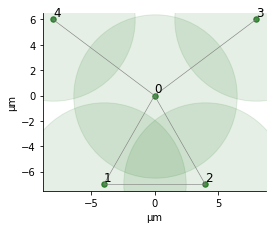

In [3]:
pos = np.array([[0., 0.], [-4, -7], [4,-7], [8,6], [-8,6]])

G = pos_to_graph(pos) 
qubits = dict(enumerate(pos))

reg = Register(qubits)
reg.draw(blockade_radius=Chadoq2.rydberg_blockade_radius(1.), draw_graph=True, draw_half_radius=True)

This graph has two maximal independent sets: $(1,3,4)$ and $(2,3,4)$, respectively `01011` and `00111` in binary. 

## 2. Building the quantum loop 

Now, we must build the quantum part of the QAOA. All atoms are initially in the groundstate $|00\dots0\rangle$ of the `ground-rydberg`basis.  We then apply $p$ layers of alternating non-commutative Hamiltonians. The first one, called the mixing Hamiltonian $H_M$, is realized by taking $\Omega = 1$ rad/µs, and $\delta = 0 $ rad/µs in the Hamiltonian equation. The second Hamiltonian $H_c$ is realized with $\Omega = \delta = 1$ rad/µs. $H_M$ and $H_c$ are applied turn in turn with parameters $\tau$ and $t$ respectively. A classical optimizer is then used to estimate the optimal parameters. 

Experimentally, we don't have access to the state vector $|\psi\rangle$. We therefore make it more realistic by taking samples from the state vector that results from running the simulation with `simul.run()`. This is done with the built-in method `results.sample_final_state()`, in which we add the measurement basis which was declared at the end of the sequence, and the number of samples desired. Currently, the repetition rate of the machine is $5$Hz.

In [4]:
def quantum_loop(param, r=reg):
    seq = Sequence(r, Chadoq2)
    seq.declare_channel('ch0','rydberg_global')
    middle = len(param)//2
    
    for tau, t in zip(param[middle:], param[:middle]):
        pulse_1 = Pulse.ConstantPulse(tau, 1., 0, 0) # H_M 
        pulse_2 = Pulse.ConstantPulse(t, 1., 1., 0) # H_M + H_c 
        seq.add(pulse_1, 'ch0')
        seq.add(pulse_2, 'ch0')
    
    seq.measure('ground-rydberg')
    simul = Simulation(seq, sampling_rate=.001)
    results = simul.run()
    count_dict = results.sample_final_state() #sample from the state vector 
    return count_dict 

In [5]:
example_dict = quantum_loop([2000,5000], r = reg)

We can then plot the distribution of the samples, to see the most frequent bitstrings sampled.

In [6]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ['01011', '00111']  # MIS indexes
    color_dict = {key:'r' if key in indexes else 'g' for key in C}
    plt.figure(figsize=(12,6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color = color_dict.values())
    plt.xticks(rotation='vertical')
    plt.show()

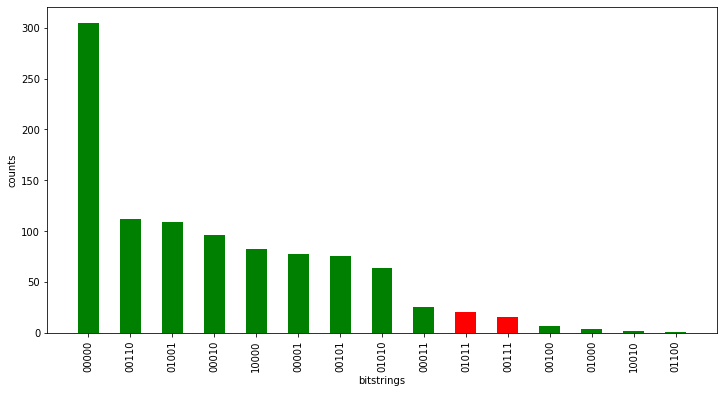

In [7]:
plot_distribution(example_dict)

The bitstrings `01011` and `00111` (in red) correspond to the two MIS of the graph. The goal of QAOA is to choregraph interferences between the basis states, in order to maximize the frequency of the MIS states. 

## 3. Optimization 

We estimate the cost of a sampled state vector by making an average over the samples. This is done by taking the corresponding bitstring ${\bf z}=(z_1, \ldots, z_N)$ and calculating 
$$
C({\bf z}) = - \sum_i z_i + \sum_{i\geq j} pA_{ij}z_iz_j  = p\,({\bf z}^\top \cdot A^\textsf{U} \cdot {\bf z}) - |{\bf z}|_0,
$$
where $A^\textsf{U}$ is the upper triangular part of the adjacency matrix of the graph, $|\cdot|_0$ gives the sum of non-zero terms of the bitstring, and $p$ is the "penalty" introduced by the magnitude of the quadratic term.

Determining the cost of a given bitstring takes polynomial time. The average estimate is then used in the classical loop to optimize the variational parameters $\tau$ and $t$.

In [8]:
def get_cost_colouring(bitstring, G, penalty=10):
    z = np.array(list(bitstring), dtype=int)
    A = np.array(G.get_adjacency().data)
    # Add penalty and bias:
    cost = penalty*(z.T @ np.triu(A) @ z) - np.sum(z)
    return cost 

def get_cost(counter,G):
    cost = sum(counter[key] * get_cost_colouring(key,G) for key in counter) 
    return cost / sum(counter.values()) # Divide by total samples

In [9]:
get_cost_colouring('00111', G)

-3

In [10]:
get_cost(example_dict, G)

-1.129

In [11]:
def func(param,*args):
    G = args[0]
    C = quantum_loop(param, r=reg)
    cost = get_cost(C,G)
    return cost

### QAOA for depth $p = 1$

We now use a classical optimizer `minimize` in order to find the best variational parameters. This function takes as arguments `func`, the graph `G`and an initial `x0` point for the simplex in Nelder-Mead minimization. The initial point `x0` was estimated beforehand using the best of many initial points, greatly facilitating the optimization process. 

In [12]:
res = minimize(func, args=G, x0=np.array([1000,9000]),method='Nelder-Mead', tol=1e-5,options = {'maxiter': 15})

/Users/seb/Documents/Projects/pasqal/Pulser/pulser/utils.py:38: UserWarning: The given duration is below the machine's precision of 4 ns time steps. It was rounded down to the nearest multiple of 4 ns.
  warnings.warn("The given duration is below the machine's precision"


We can now plot the sample that we woud obtain using the variational parameters `res.x`.

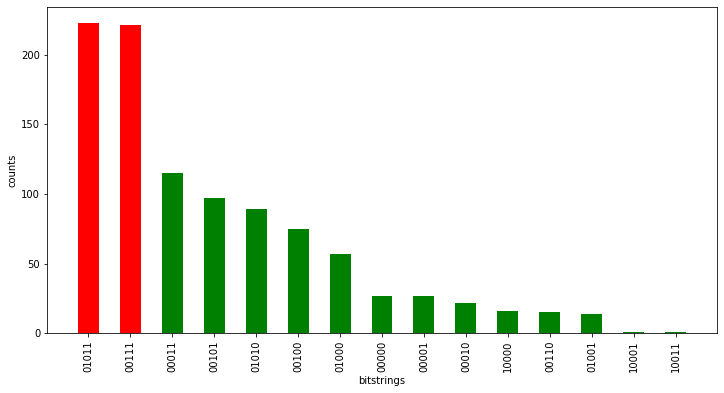

In [13]:
count_dict = quantum_loop(res.x)
plot_distribution(count_dict)

QAOA is capable of finding good variational parameters $\tau$ and $t$. Now, sampling from this final state $|\psi(t_{f})\rangle$ will return both MISs of the graph with high probability. Note that listing all maximal independent sets of a graph is also NP, and can be used as a subroutine for solving many NP-complete graph problems. 